In [0]:
!pip install catboost

In [109]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [0]:
#functions
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def plot_distribution(df, var_select=None, title=None, bins=1.0): 
    # Calculate the correlation coefficient between the new variable and the target
    tmp_fraud = df[df['isFraud'] == 1]
    tmp_no_fraud = df[df['isFraud'] == 0]    
    corr = df['isFraud'].corr(df[var_select])
    corr = np.round(corr,3)
    tmp1 = tmp_fraud[var_select].dropna()
    tmp2 = tmp_no_fraud[var_select].dropna()
    hist_data = [tmp1, tmp2]
    
    group_labels = ['Fraud', 'No Fraud']
    colors = ['seagreen','indianred', ]

    fig = ff.create_distplot(hist_data,
                             group_labels,
                             colors = colors, 
                             show_hist = True,
                             curve_type='kde', 
                             bin_size = bins
                            )
    
    fig['layout'].update(title = title+' '+'(corr target ='+ str(corr)+')')

    iplot(fig, filename = 'Density plot')
    
def plot_dist_churn(df, col, binary=None):
    tmp_churn = df[df[binary] == 1]
    tmp_no_churn = df[df[binary] == 0]
    tmp_attr = round(tmp_churn[col].value_counts().sort_index() / df[col].value_counts().sort_index(),2)*100
    print(f'Distribution of {col}: ')
    trace1 = go.Bar(
        x=tmp_churn[col].value_counts().sort_index().index,
        y=tmp_churn[col].value_counts().sort_index().values, 
        name='Fraud',opacity = 0.8, marker=dict(
            color='seagreen',
            line=dict(color='#000000',width=1)))

    trace2 = go.Bar(
        x=tmp_no_churn[col].value_counts().sort_index().index,
        y=tmp_no_churn[col].value_counts().sort_index().values,
        name='No Fraud', opacity = 0.8, 
        marker=dict(
            color='indianred',
            line=dict(color='#000000',
                      width=1)
        )
    )

    trace3 =  go.Scatter(   
        x=tmp_attr.sort_index().index,
        y=tmp_attr.sort_index().values,
        yaxis = 'y2', 
        name='% Fraud', opacity = 0.6, 
        marker=dict(
            color='black',
            line=dict(color='#000000',
                      width=2 )
        )
    )
    
    layout = dict(title =  f'Distribution of {str(col)} feature by %Fraud',
              xaxis=dict(type='category'), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [0, 15], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= 'Percentual Fraud Transactions'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    iplot(fig)

In [0]:
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import cufflinks as cf
import plotly.figure_factory as ff


In [69]:
# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)

In [70]:
import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import os

# Any results you write to the current directory are saved as output.
print ("Ready!")

Ready!


In [71]:
# from google.colab import files
# import io
# uploaded = files.upload()
# train_transaction = pd.read_csv(io.StringIO(uploaded['imbalancedFraudDF.csv'].decode('utf-8')))
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_transaction = pd.read_csv('/content/drive/My Drive/data/train_transaction.csv')
train_identity = pd.read_csv('/content/drive/My Drive/data/train_identity.csv')
test_transaction = pd.read_csv('/content/drive/My Drive/data/test_transaction.csv')
test_identity = pd.read_csv('/content/drive/My Drive/data/test_identity.csv')

In [73]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [74]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [76]:
missing_values_count = train_transaction.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_transaction.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

TransactionID        0
isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
dtype: int64
% of missing data =  41.073431200111266


In [77]:
missing_values_count = train_identity.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_identity.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
dtype: int64
% of missing data =  35.58109650830896


In [0]:
x = train_transaction['isFraud'].value_counts().index
y = train_transaction['isFraud'].value_counts().values

trace2 = go.Bar(
     x=x ,
     y=y,
     marker=dict(
         color=y,
         colorscale = 'Viridis',
         reversescale = True
     ),
     name="Imbalance",    
 )
layout = dict(
     title="Data imbalance - isFraud",
     #width = 900, height = 500,
     xaxis=go.layout.XAxis(
     automargin=True),
     yaxis=dict(
         showgrid=False,
         showline=False,
         showticklabels=True,
 #         domain=[0, 0.85],
     ), 
)
fig1 = go.Figure(data=[trace2], layout=layout)
iplot(fig1)

In [79]:
del x,y
gc.collect()

7267

In [80]:
# Here we confirm that all of the transactions in `train_identity`
print(np.sum(train_transaction.index.isin(train_identity.index.unique())))
print(np.sum(test_transaction.index.isin(test_identity.index.unique())))

144233
141907


In [81]:
train_transaction['TransactionDT'].head()

0    86400
1    86401
2    86469
3    86499
4    86506
Name: TransactionDT, dtype: int64

In [82]:
train_transaction['TransactionDT'].shape[0] , train_transaction['TransactionDT'].nunique()

(590540, 573349)

In [83]:
train_transaction['TransactionDT'].value_counts().head(10)

9474817     8
11576951    5
7236588     5
4397066     5
8468062     4
8020359     4
7337054     4
5334992     4
1971839     4
1962054     4
Name: TransactionDT, dtype: int64

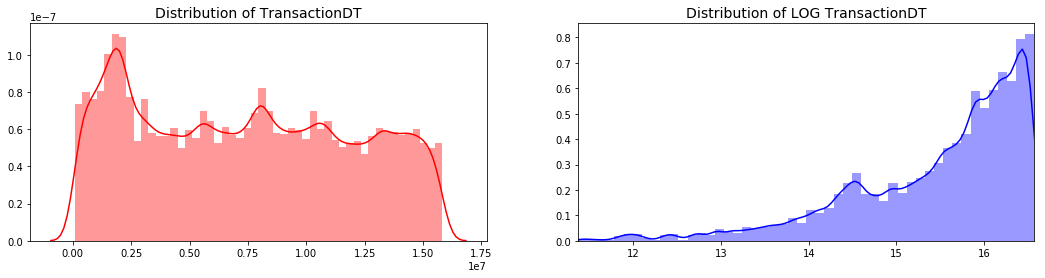

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction['TransactionDT'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionDT', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

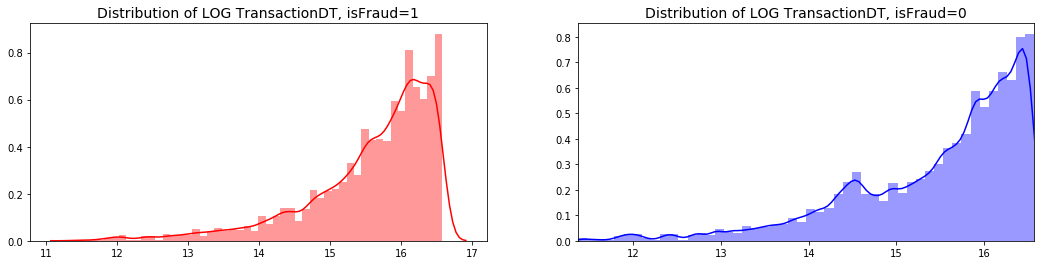

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionDT, isFraud=1', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

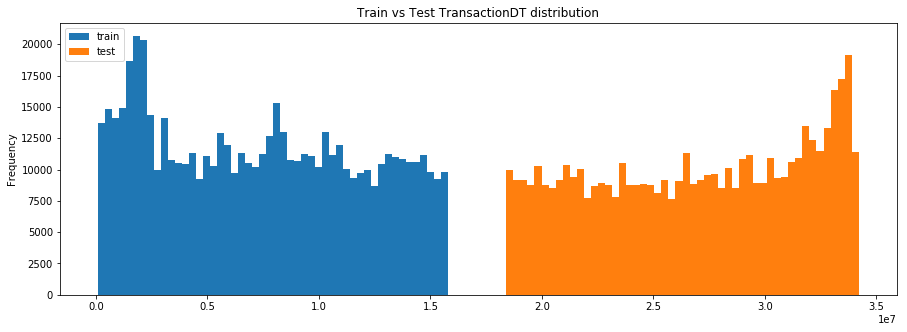

In [86]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

As you can see it seems that train and test transaction dates don't overlap, so it would be prudent to use time-based split for validation.

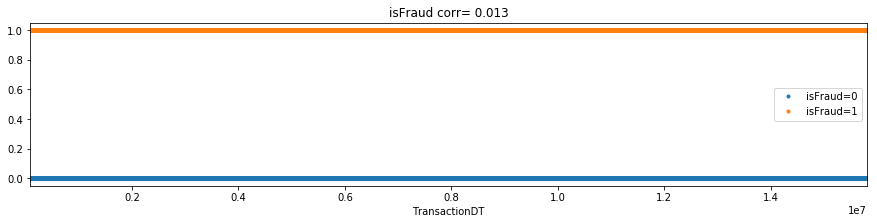

In [87]:
i = 'isFraud'
cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
train_transaction.loc[train_transaction['isFraud'] == 0].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
train_transaction.loc[train_transaction['isFraud'] == 1].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
#test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
plt.legend()
plt.show()

In [0]:
d_features = list(train_transaction.columns[30:45])

# for i in d_features:
#     cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
#     train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
#     test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
#     plt.show()

In [89]:
train_transaction[d_features].head()

,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14
0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN
1,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN
3,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN
4,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
# Click output to see the number of missing values in each column
missing_values_count = train_transaction[d_features].isnull().sum()
missing_values_count

C14         0
D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
dtype: int64

In [91]:
# how many total missing values do we have?
total_cells = np.product(train_transaction[d_features].shape)
total_missing = missing_values_count.sum()
# percent of data that is missing
(total_missing/total_cells) * 100

57.14525688353033

The problem of D feature is missing value

In [92]:
m_features = list(train_transaction.columns[45:54])
train_transaction[m_features].head()

,D15,M1,M2,M3,M4,M5,M6,M7,M8
0,0.0,T,T,T,M2,F,T,NaN,NaN
1,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN
2,315.0,T,T,T,M0,F,F,F,F
3,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


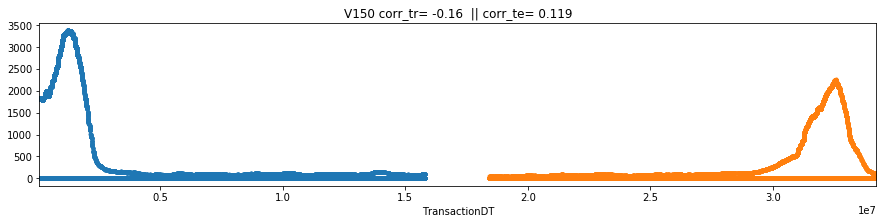

In [93]:
i = "V150"
cor_tr = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i].fillna(-1))[0,1]
cor_te = np.corrcoef(test_transaction['TransactionDT'], test_transaction[i].fillna(-1))[0,1]
train_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+" || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
test_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+"  || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
plt.show()

In [94]:
# merge tables
%%time
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
y_train = train['isFraud'].astype("uint8").copy()
print("Tain: ",train.shape)
del train_transaction, train_identity

test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
print("Test: ",test.shape)
del test_transaction, test_identity
print ("Merged!")

Tain:  (590540, 435)
Test:  (506691, 434)
Merged!
CPU times: user 3.57 s, sys: 1.28 s, total: 4.85 s
Wall time: 4.84 s


In [95]:
%%time
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test
gc.collect()

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))

CPU times: user 1min, sys: 2.71 s, total: 1min 3s
Wall time: 1min 3s


In [96]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.06 µs


In [97]:
%%time
X_train = reduce_mem_usage2(X_train)
X_test = reduce_mem_usage2(X_test)

Memory usage of dataframe is 1955.37 MB
Memory usage after optimization is: 527.14 MB
Decreased by 73.0%
Memory usage of dataframe is 1677.73 MB
Memory usage after optimization is: 460.02 MB
Decreased by 72.6%
CPU times: user 4min 41s, sys: 11.1 s, total: 4min 52s
Wall time: 4min 52s


In [98]:
X_train.head(3)

,TransactionID_x,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,86400,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,NaN,32,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,1,NaN,-480.0,1,1,166.0,NaN,542.0,144.0,NaN,NaN,3,NaN,NaN,NaN,2,1,1,7,162,32.0,268,3,1,0,1,1,1,1565
1,2987001,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,NaN,NaN,16,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,1,49.0,-300.0,1,1,166.0,NaN,621.0,500.0,NaN,NaN,3,NaN,NaN,NaN,2,1,1,70,130,32.0,80,2,1,0,0,1,1,2693
2,2987002,86469,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,287.0,NaN,36,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,1,52.0,NaN,0,0,121.0,NaN,410.0,142.0,NaN,NaN,3,NaN,NaN,NaN,2,0,0,86,46,NaN,461,4,0,0,1,1,0,2526


In [99]:
X_test.head(3)

,TransactionID_x,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,4,10409,111.0,150.0,4,226.0,2,170.0,87.0,1.0,NaN,16,32,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,1,27.0,NaN,1,1,225.0,15.0,427.0,563.0,NaN,NaN,3,NaN,NaN,NaN,2,1,1,86,62,NaN,461,4,0,0,1,0,1,1168
1,3663550,18403263,49.000000,4,4272,111.0,150.0,4,226.0,2,299.0,87.0,4.0,NaN,2,32,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,0,NaN,-300.0,0,0,166.0,NaN,542.0,368.0,NaN,NaN,3,NaN,NaN,NaN,2,0,0,6,62,24.0,62,3,1,0,1,1,1,1031
2,3663551,18403310,171.000000,4,4476,574.0,150.0,4,226.0,2,472.0,87.0,2636.0,NaN,19,32,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,1,52.0,-360.0,1,1,225.0,NaN,271.0,507.0,NaN,NaN,3,NaN,NaN,NaN,2,1,1,86,124,NaN,461,4,0,1,1,0,0,2459


In [100]:
logging.debug("memory usage!")

DEBUG:root:memory usage!


In [101]:
#drop_col = ['TransactionDT', 'V300', 'V309', 'V111', 'C3', 'V124', 'V106', 'V125', 'V315', 'V134', 'V102', 'V123', 'V316', 'V113', 'V136', 'V305', 'V110', 'V299', 'V289', 'V286', 'V318', 'V103', 'V304', 'V116', 'V298', 'V284', 'V293', 'V137', 'V295', 'V301', 'V104', 'V311', 'V115', 'V109', 'V119', 'V321', 'V114', 'V133', 'V122', 'V319', 'V105', 'V112', 'V118', 'V117', 'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120']
drop_col = ['TransactionDT']
X_train.drop(drop_col,axis=1, inplace=True)
X_test.drop(drop_col, axis=1, inplace=True)
X_train.head()

,TransactionID_x,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,NaN,32,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,1,NaN,-480.0,1,1,166.0,NaN,542.0,144.0,NaN,NaN,3,NaN,NaN,NaN,2,1,1,7,162,32.0,268,3,1,0,1,1,1,1565
1,2987001,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,NaN,NaN,16,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,1,49.0,-300.0,1,1,166.0,NaN,621.0,500.0,NaN,NaN,3,NaN,NaN,NaN,2,1,1,70,130,32.0,80,2,1,0,0,1,1,2693
2,2987002,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,287.0,NaN,36,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,...,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,1,52.0,NaN,0,0,121.0,NaN,410.0,142.0,NaN,NaN,3,NaN,NaN,NaN,2,0,0,86,46,NaN,461,4,0,0,1,1,0,2526
3,2987003,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,NaN,NaN,55,32,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,...,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,1,52.0,NaN,1,1,225.0,NaN,176.0,507.0,NaN,NaN,3,NaN,NaN,NaN,2,1,1,86,46,NaN,461,4,0,0,1,1,0,2740
4,2987004,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,87.0,NaN,NaN,16,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,1,NaN,-300.0,0,0,166.0,15.0,529.0,575.0,NaN,NaN,3,NaN,NaN,NaN,2,0,0,26,46,24.0,68,3,1,0,1,1,0,1170


In [102]:
X_train.fillna(-1,inplace=True)
X_test.fillna(-1,inplace=True)
X_train.head()

,TransactionID_x,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,68.5,4,13926,-1.0,150.0,1,142.0,1,315.0,87.0,19.0,-1.0,32,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-1.0,13.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,13.0,13.0,...,0.0,70787.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,100.0,1,-1.0,-480.0,1,1,166.0,-1.0,542.0,144.0,-1.0,-1.0,3,-1.0,-1.0,-1.0,2,1,1,7,162,32.0,268,3,1,0,1,1,1,1565
1,2987001,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,-1.0,-1.0,16,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,...,-5.0,98945.0,-1.0,-1.0,0.0,-5.0,-1.0,-1.0,-1.0,-1.0,100.0,1,49.0,-300.0,1,1,166.0,-1.0,621.0,500.0,-1.0,-1.0,3,-1.0,-1.0,-1.0,2,1,1,70,130,32.0,80,2,1,0,0,1,1,2693
2,2987002,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,287.0,-1.0,36,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,315.0,...,-5.0,191631.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,100.0,1,52.0,-1.0,0,0,121.0,-1.0,410.0,142.0,-1.0,-1.0,3,-1.0,-1.0,-1.0,2,0,0,86,46,-1.0,461,4,0,0,1,1,0,2526
3,2987003,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,-1.0,-1.0,55,32,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,-1.0,-1.0,-1.0,-1.0,84.0,-1.0,...,-5.0,221832.0,-1.0,-1.0,0.0,-6.0,-1.0,-1.0,-1.0,-1.0,100.0,1,52.0,-1.0,1,1,225.0,-1.0,176.0,507.0,-1.0,-1.0,3,-1.0,-1.0,-1.0,2,1,1,86,46,-1.0,461,4,0,0,1,1,0,2740
4,2987004,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,87.0,-1.0,-1.0,16,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,7460.0,0.0,0.0,1.0,0.0,-1.0,-1.0,0.0,0.0,100.0,1,-1.0,-300.0,0,0,166.0,15.0,529.0,575.0,-1.0,-1.0,3,-1.0,-1.0,-1.0,2,0,0,26,46,24.0,68,3,1,0,1,1,0,1170


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f3b2aa41390>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f3b2aa41390>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


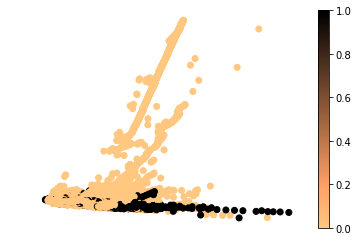

In [103]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)         
PCA_train_x = PCA(2).fit_transform(train_scaled)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0 to STIXGeneral ('/usr/loc

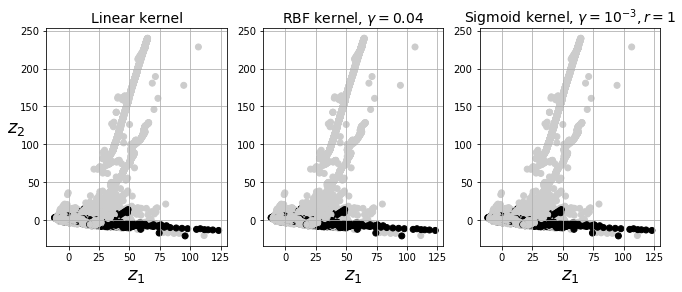

In [104]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    PCA_train_x = PCA(2).fit_transform(train_scaled)
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap="nipy_spectral_r")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [105]:
del train_scaled,PCA_train_x,scaler, lin_pca,rbf_pca, sig_pca
gc.collect()

11316

In [113]:
xgb.XGBClassifier(
        n_estimators=500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma = 0.1,
        alpha = 4,
        missing = -1,
        tree_method='gpu_hist'
)

XGBClassifier(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-1, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=1)

In [112]:
%%time
NFOLDS = 5
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=123)

y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
  
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    clf = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma = 0.2,
        alpha = 4,
        missing = -1,
        tree_method='hist'
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print("FOLD: ",fold,' AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    score += roc_auc_score(y_vl, y_pred_train) / NFOLDS
    y_preds+= clf.predict_proba(X_test)[:,1] / NFOLDS
    
    del X_tr, X_vl, y_tr, y_vl
    gc.collect()
    
    
print("\nMEAN AUC = {}".format(score))
print("OOF AUC = {}".format(roc_auc_score(y_train, y_oof)))

FOLD:  0  AUC 0.9607988028636726
FOLD:  1  AUC 0.9643191264210356
FOLD:  2  AUC 0.96188315394043
FOLD:  3  AUC 0.9600820075053398
FOLD:  4  AUC 0.9610171587024974

MEAN AUC = 0.961620049886595
OOF AUC = 0.9616246368102712
CPU times: user 1h 22min 15s, sys: 15.3 s, total: 1h 22min 31s
Wall time: 1h 22min 31s


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


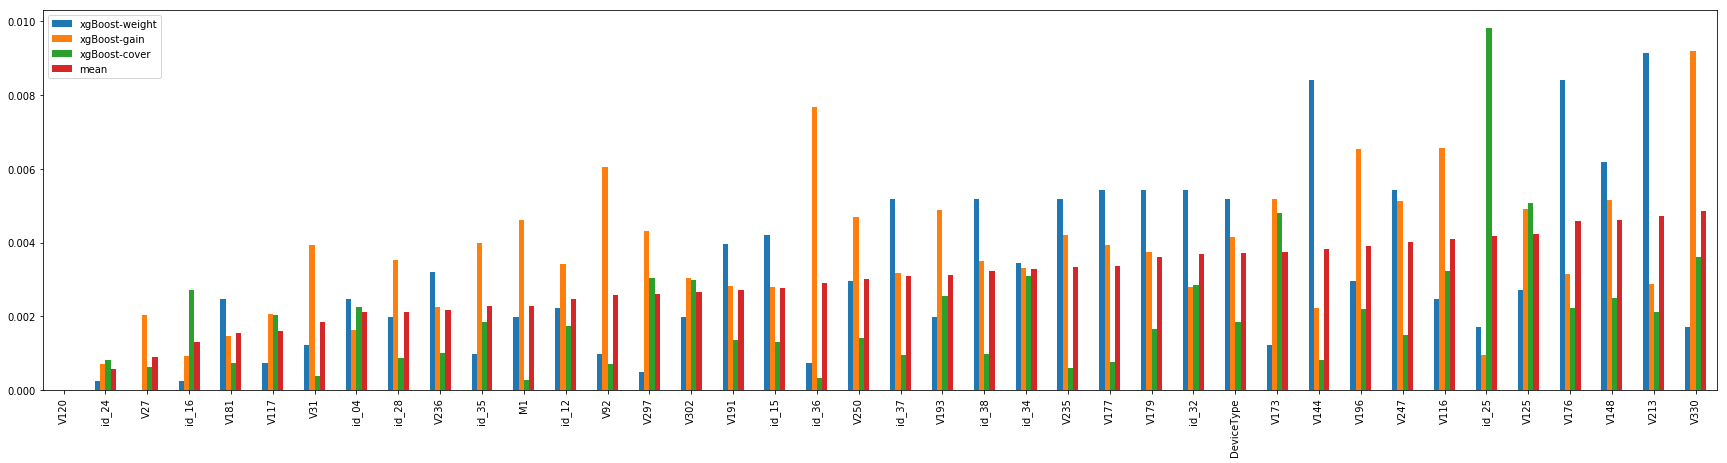

In [114]:
# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').head(40).plot(kind='bar', figsize=(30, 7))

In [117]:
sub = pd.read_csv('/content/drive/My Drive/data/sample_submission.csv')
sub['isFraud'] = y_preds
sub.to_csv('xgboost.csv')
sub.head()

,TransactionID,isFraud
0,3663549,0.003304
1,3663550,0.001325
2,3663551,0.004481
3,3663552,0.001267
4,3663553,0.001237


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


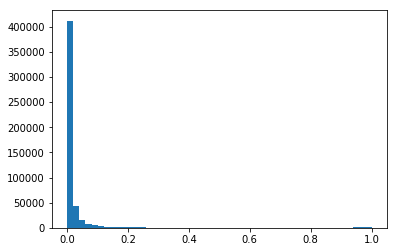

In [120]:
sub.loc[ sub['isFraud']>0.99 , 'isFraud'] = 1
b = plt.hist(sub['isFraud'], bins=50)
# print ("Predicted {} frauds".format(int(sub[sub['isFraud']==1].sum())))